## Assignment A5: Signal Representation

### John Mays (jkm100)

In [1]:
# Αα,Ββ,Γγ,Δδ,Εε,Ζζ,Ηη,Θθ,Ιι,Κκ,Λλ,Μμ,Νν,Ξξ,Οο,Ππ,Ρρ,Σσ/ς,Ττ,Υυ,Φφ,Χχ,Ψψ,Ωω
purples = ["#0a0612", "#392249", "#482980", "#673ab7",
           "#7a52aa", "#9779bd", "#b59fd0", "#d3c5e3"];

In [2]:
using Plots
using Random, Distributions
using LinearAlgebra
using DSP
using FFTW

In [3]:
include("464-A4-jkm100.jl")
# include("464-A5-jkm100.jl")

decay (generic function with 1 method)

### 1. Basis functions of the discrete Fourier transform

#### 1a. Visualizing the Complex Representation of a Fourier Basis

I couldn't exactly tell what you wanted, so if you specify a frequency k it'll plot that.  Otherwise, it will plot $N$ vectors for $k = 0 \dots N-1$.

In [21]:
function plotfourierbasis(N; k = nothing)
    # plotting the unit circle
    xₜ(t) = sin(t)
    yₜ(t) = cos(t)
    plot(xₜ, yₜ, 0, 2π, leg=false, color = "black", 
    size = (400,400),framestyle = :origin,
    title="Fourier Basis", xlabel = "Re", ylabel = "Im",
    titlefontsize = 12, xguidefontsize = 8, yguidefontsize = 8, tickfontsize = 6,
    xlim = (-1.5, 1.5), ylim = (-1.5, 1.5)
    )
    # plotting the vectors
    if k isa Number
        ω = (2*pi*k)/N
        basis = exp(im*ω)
        plot!([0,real(basis)], [0,imag(basis)], color = purples[5], lw=2)
    else
        basis = zeros(ComplexF64,N)
        for k = 0:(N-1)
            ω = (2*pi*k)/N
            basis[k+1] = exp(im*ω)
            plot!([0,real(basis[k+1])], [0,imag(basis[k+1])], color = purples[5], lw=1)
            
        end
    end
    # print(round.(basis, digits =3)) 
    plot!()
end

plotfourierbasis (generic function with 1 method)

##### Partial Re-creation of Fig. 4.1 from Prandoni & Vetterli:

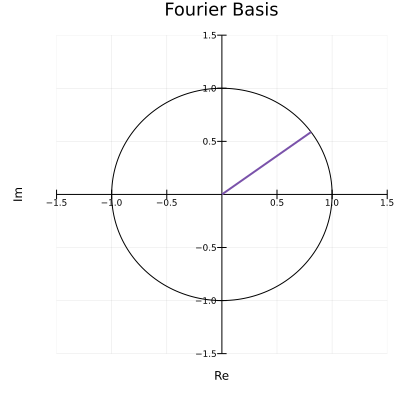

In [19]:
plotfourierbasis(100, k=10)

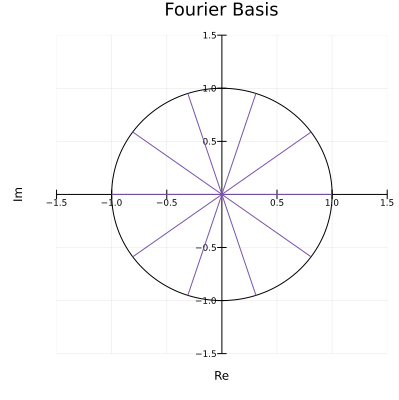

In [20]:
plotfourierbasis(10)

#### 1b. Visualizing the basis functions

In [22]:
function w(n, k, N)
    ω = (2*pi*k)/N
    return exp(im * ω * n)
end

w (generic function with 1 method)

In [23]:
w(1, 4, 1000)

0.9996841892832999 + 0.02513009544333748im

In [24]:
function plotw(k, N)
    basis = zeros(ComplexF64,N)
    for n = 0:(N-1)
        basis[n+1] = w(n, k, N)
    end
    real_plot = plot(real(basis), line=:stem, ylabel="Re", label=false,
    color = purples[3])
    imag_plot = plot(imag(basis), line=:stem, ylabel="Im", label=false,
    color = purples[3])
    
    plot(real_plot, imag_plot,
    layout = (2,1), size = (500, 250), xguidefontsize = 8, yguidefontsize = 8
    )
end 

plotw (generic function with 1 method)

##### Re-creation of Fig. 4.5 from Prandoni & Vetterli: *Basis Vector $w^{31}\in \mathbb{C}^{32}$*

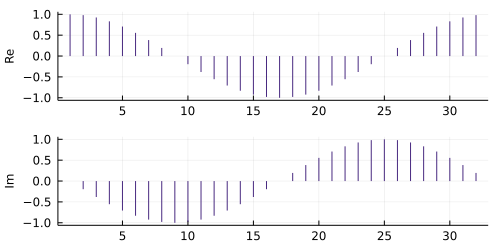

In [25]:
plotw(31, 32)

#### 1c. Orthogonality

Here are the plots of two different basis vectors ($k=1$ and $k=2$)

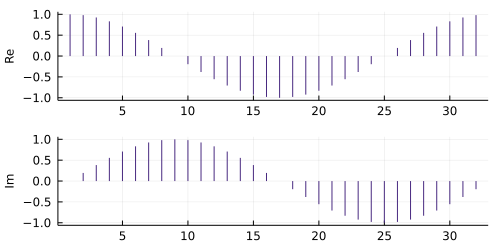

In [26]:
plotw(1, 32)

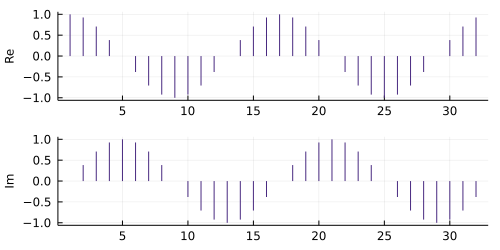

In [27]:
plotw(2, 32)

I can recreate the bases made inside of the plotting functions here:

In [28]:
N = 32
w1 = zeros(ComplexF64,N)
for n = 0:(N-1)
    w1[n+1] = w(n, 1, N)
end
w2 = zeros(ComplexF64,N)
for n = 0:(N-1)
    w2[n+1] = w(n, 2, N)
end

And if I take the two bases' inner (dot) product $\langle w^{1},  w^{2} \rangle =  w^{1} \cdot w^{2}$, it should be zero if they are orthogonal.

In [29]:
println(dot(w1, w2))

-1.6022378597616245e-15 + 2.8847096981041696e-16im


And it is.  Nearly zero on the order of *Float64* precision.  Orthonormativity would require the extra condition that the two bases be normal vectors (having 2-norm of 1).  Do they?

In [30]:
println(norm(w1, 2))
println(norm(w2, 2))

5.656854249492381
5.656854249492381


No, they don't.  Their norms are not 1.  Therefore they are orthogonal, just not orthonormal.  Looking at the plots and realizing that every basis vector is just a frequency multiple of $w^{1}$ (with the same norm), this property should be mutual among the entire set of basis vectors.

### 2. Fourier analysis in matrix-vector form

#### 2a.  Constructing the basis matrix

In [31]:
function fourier_matrix(N::Int64)
    A = zeros(ComplexF64, (N,N))
    for row = 1:N
        n = row - 1
        for col = 1:N
            k = col - 1
            A[row, col] = w(n, k, N)
        end
    end
    return A
end;

In [32]:
display(round.(fourier_matrix(5), digits=5))

5×5 Matrix{ComplexF64}:
 1.0+0.0im       1.0+0.0im           1.0+0.0im      …       1.0+0.0im
 1.0+0.0im   0.30902+0.95106im  -0.80902+0.58779im      0.30902-0.95106im
 1.0+0.0im  -0.80902+0.58779im   0.30902-0.95106im     -0.80902-0.58779im
 1.0+0.0im  -0.80902-0.58779im   0.30902+0.95106im     -0.80902+0.58779im
 1.0+0.0im   0.30902-0.95106im  -0.80902-0.58779im      0.30902+0.95106im

#### 2b. Fourier matrix properties

When I take the conjugate transpose and multiply by the orginal matrix, I get $A^{-1}A = A'A = NI = 5I$:

In [33]:
A = fourier_matrix(5)
Ainv = copy(A)'
NI = Ainv * A
display(round.(NI, digits=4))

5×5 Matrix{ComplexF64}:
  5.0+0.0im  -0.0+0.0im   0.0+0.0im   0.0+0.0im   0.0+0.0im
 -0.0-0.0im   5.0+0.0im  -0.0+0.0im   0.0+0.0im   0.0+0.0im
  0.0-0.0im  -0.0-0.0im   5.0+0.0im   0.0+0.0im  -0.0+0.0im
  0.0-0.0im   0.0-0.0im   0.0-0.0im   5.0+0.0im  -0.0+0.0im
  0.0-0.0im   0.0-0.0im  -0.0-0.0im  -0.0-0.0im   5.0+0.0im

#### 2c. Comparing to the standard `fft` function.

In [38]:
# Making Random vector
y = rand(-1.0:eps():1.0, 5)

5-element Vector{Float64}:
 -0.1143520894180039
 -0.3356874045959737
 -0.5761324564501351
 -0.8931973905491595
  0.2346998556373343

In [39]:
# Mine:
s_matrix = fourier_matrix(5)*y

5-element Vector{ComplexF64}:
  -1.6846694853759379 + 0.0im
   1.0431538582982751 - 0.35610442837413586im
 -0.48669933915531627 - 0.6368118913242179im
  -0.4866993391553157 + 0.6368118913242183im
   1.0431538582982753 + 0.3561044283741351im

In [40]:
# Built In:
s_fft = fft(y)

5-element Vector{ComplexF64}:
 -1.6846694853759379 + 0.0im
  1.0431538582982751 + 0.35610442837413564im
  -0.486699339155316 + 0.636811891324218im
  -0.486699339155316 - 0.636811891324218im
  1.0431538582982751 - 0.35610442837413564im

THEY ARE THE SAME!

#### 2d. Benchmarking

Since the command fft is not only producing a matrix (supposedly ... perhaps not), but also multiplying the input vector by it, it woul make sense to benchmark against the bundled runtime of both of those actions in order to be fair. 

So, here I will create a function called `myfft(x)` that does that.
 - It will find the length of the input vector $y\rightarrow N$
 - It will call `fourier_matrix(`$N$`)`
 - It will return that matrix ($A$) times the input vector $y$.

In [50]:
function myft(y)
    N = length(y)
    return fourier_matrix(N)*y
end

myft (generic function with 1 method)

In [66]:
# creating random vector of large size:
y = rand(-1.0:eps():1.0, 18000);

In [67]:
myft(y);

In [68]:
fft(y);

It looks as if my function takes many, many times as long as the fast fourier function.  The runtime from julia cells is pretty unreliable, but I will plot one run of times I got from my machine:

In [ ]:
Ns = [10000, 12000, 14000, 16000, 18000]
mytimes = [5.4, 8.5, 11.3, 13.9, ]
ffttimes = [0.2, 0.2, 0.3, 0.3, ]

#### 2e. Synthesizing bandpass noise

### 3. Transforms in 2D